## Test compare the chemistry.py

In [1]:
import numpy as np
import pyc2ray as p2c
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

2024-07-03 10:06:12.904824: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 10:06:13.236687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 10:06:13.236733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 10:06:13.277581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 10:06:13.380067: I tensorflow/core/platform/cpu_feature_guar

### Define fields
in this example we define some random density fields for the gas density <b>ndens</b>, temperature <b>temp</b>, ionization fraction <b>xh</b> and photo-ionization rate <b>phi_ion</b>.</br>
These four field can be a single value or a numpy array with the same shape.

In [2]:
#mesh_shape = (10,10,10)
mesh_shape = (1,1,1)

np.random.seed(2023)
# density field [g/cm^3]
ndens = np.ones(mesh_shape)*1e-6

# temperature [K]
temp = np.ones(mesh_shape)*1e4

# clumping factor
clumping = np.ones(mesh_shape)

# Hydrogen ionization fraction
xh = np.ones(mesh_shape)*0.1 #np.random.uniform(low=0, high=0.1, size=mesh_shape)
xh_ini = xh.copy()
print(xh_ini)
# photo-ionization rate [s^-1]
phi_ion = np.random.uniform(low=1e-13, high=1e-12, size=mesh_shape)

[[[0.1]]]


### Define the time-step loop

In [3]:
# time-step
dt = 50*u.yr
t_steps = 10000

print('Volume-averaged ionized fraction at t=0: %.3f' %np.mean(xh_ini))

# calculate ODE
t_arr = np.arange(t_steps)*dt.value
xh_arr = np.zeros(t_steps)
for i in range(t_steps):
    new_xh = p2c.solver.hydrogenODE(dt=dt.cgs.value, ndens=ndens, temp=temp, xh=xh, phi_ion=phi_ion, clump=clumping)
    xh = new_xh
    xh_arr[i] = xh

print('Volume-averaged ionized fraction after t=%d %s: %.3f' %(dt.value*t_steps, dt.unit, np.mean(xh)))

Volume-averaged ionized fraction at t=0: 0.100
Volume-averaged ionized fraction after t=500000 yr: 0.998


### Plot the results

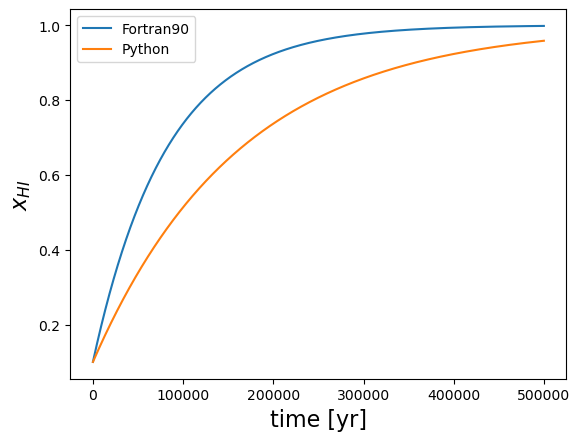

In [25]:
plt.plot(t_arr, xh_arr, label='Fortran90')
plt.plot(t_arr, xh_arr2, label='Python')
plt.xlabel('time [yr]', size=16), plt.ylabel(r'$x_{HI}$', size=16)
plt.legend()

In [10]:
# Define constants
epsilon = 1e-14
minimum_fractional_change = 1.0e-3
minimum_fraction_of_atoms = 1.0e-8

def doric(xh_old, dt, temp_p, rhe, phi_p, bh00, albpow, colh0, temph0, clumping):
    # Calculate the hydrogen recombination rate at the local temperature
    brech0 = clumping * bh00 * (temp_p / 1e4)**albpow

    # Calculate the hydrogen collisional ionization rate at the local temperature
    acolh0 = colh0 * np.sqrt(temp_p) * np.exp(-temph0 / temp_p)

    # Find the true photo-ionization rate
    aphoth0 = phi_p

    # Determine ionization states
    aih0 = aphoth0 + rhe * acolh0
    delth = aih0 + rhe * brech0
    eqxh = aih0 / delth
    deltht = delth * dt
    ee = np.exp(-deltht)
    xh = (xh_old - eqxh) * ee + eqxh

    # Handle precision fluctuations
    xh = np.maximum(xh, epsilon)

    # Determine average ionization fraction over the time step
    avg_factor = np.where(deltht < 1.0e-8, 1.0, (1.0 - ee) / deltht)
    xh_av = eqxh + (xh_old - eqxh) * avg_factor
    xh_av = np.maximum(xh_av, epsilon)

    return xh, xh_av

def do_chemistry(dt, ndens_p, temperature_start, xh_p, xh_av_p, xh_intermed_p, phi_ion_p, clump_p, bh00, albpow, colh0, temph0, abu_c):
    # Initialize local quantities
    temperature_end = temperature_start
        
    # Calculate the new and mean ionization states
    #xh_intermed = np.copy(xh)  # Placeholder, actual intermediate state calculation may vary

    convergence, niter = False, 0
    while not convergence:
        # Save temperature solution from last iteration
        temperature_previous_iteration = temperature_end

        # At each iteration, the intial condition x(0) is reset. Change happens in the time-average and thus the electron density
        xh_av_p_old = xh_av_p

        # Calculate (mean) electron density
        de = ndens_p * (xh_av_p + abu_c)

        # Calculate the new and mean ionization states
        new_xh_p, new_xh_av_p = doric(xh_p, dt, temperature_end, de, phi_ion_p, bh00, albpow, colh0, temph0, clump_p)

        # Check for convergence
        cond1 = np.abs(new_xh_av_p-xh_av_p_old)/(1-new_xh_av_p) < minimum_fractional_change

        print(cond1.all())
        
        cond2 = 1 - new_xh_av_p < minimum_fraction_of_atoms
        cond3 = np.abs(temperature_end-temperature_previous_iteration)/temperature_end < minimum_fractional_change

        if((cond1 or cond2) and cond3):
            convergence = True

        # Warn about non-convergence and terminate iteration
        if(niter > 400):
            print('Warning!!! non-convergence. Therefore, terminating iteration.')
            convergence = True
        else:
            niter += 1
        
    return new_xh_p, new_xh_av_p, xh_intermed_p

def global_pass(dt, ndens, temp, xh, xh_av, xh_intermed, phi_ion, clump, bh00, albpow, colh0, temph0, abu_c):
    conv_flag = 0

    new_xh = np.zeros_like(xh)
    new_xh_av = np.zeros_like(xh)
    
    for k in range(xh.shape[0]):
        for j in range(xh.shape[1]):
            for i in range(xh.shape[2]):
                # Initialize local quantities
                temperature_start = temp[i,j,k]
                ndens_p = ndens[i,j,k]
                phi_ion_p = phi_ion[i,j,k]
                clump_p = clump[i,j,k]

                # Initialize local ion fractions
                xh_p = xh[i,j,k]
                xh_av_p = xh_av[i,j,k]
                xh_intermed_p = xh_intermed[i,j,k]

                # call do chemistry
                new_xh[i, j, k], new_xh_av[i, j, k], _ = do_chemistry(dt, ndens_p, temperature_start, xh_p, xh_av_p, xh_intermed_p, phi_ion_p, clump_p, bh00, albpow, colh0, temph0, abu_c)

                # Check for convergence (global flag). In original, convergence is tested using neutral fraction, but testing with ionized fraction should be equivalent. TODO: add temperature convergence criterion when non-isothermal mode is added later on.
                xh_av_p_old = new_xh_av[i,j,k]

                cond1 = np.abs(xh_av_p-xh_av_p_old) > minimum_fractional_change
                print(cond1)
                
                cond2 = np.abs((xh_av_p - xh_av_p_old) / (1.0 - xh_av_p)) > minimum_fractional_change
                cond3 = (1.0 - xh_av_p) > minimum_fraction_of_atoms
                if(cond1 * cond2 * cond3):
                    conv_flag += 1
                                               
    return new_xh, new_xh_av, conv_flag

def global_pass_new(dt, ndens, temp, xh, xh_av, xh_intermed, phi_ion, clump, bh00, albpow, colh0, temph0, abu_c):
    conv_flag = 0

    new_xh = np.zeros_like(xh)
    new_xh_av = np.zeros_like(xh)
    

    # Initialize local quantities
    temperature_start = temp
    ndens_p = ndens
    phi_ion_p = phi_ion
    clump_p = clump

    # Initialize local ion fractions
    xh_p = xh
    xh_av_p = xh_av
    xh_intermed_p = xh_intermed

    # call do chemistry
    new_xh, new_xh_av, _ = do_chemistry(dt, ndens_p, temperature_start, xh_p, xh_av_p, xh_intermed_p, phi_ion_p, clump_p, bh00, albpow, colh0, temph0, abu_c)

    # Check for convergence (global flag). In original, convergence is tested using neutral fraction, but testing with ionized fraction should be equivalent. TODO: add temperature convergence criterion when non-isothermal mode is added later on.
    xh_av_p_old = new_xh_av

    cond1 = np.abs(xh_av_p-xh_av_p_old) > minimum_fractional_change
    cond2 = np.abs((xh_av_p - xh_av_p_old) / (1.0 - xh_av_p)) > minimum_fractional_change
    cond3 = (1.0 - xh_av_p) > minimum_fraction_of_atoms
    if(cond1 * cond2 * cond3):
        conv_flag += 1
                                               
    return new_xh, new_xh_av, conv_flag


In [11]:
# Example usage with dummy data
m1, m2, m3 = 2, 2, 2
mesh_shape = (m1, m2, m3)
dt = (50*u.yr).cgs.value

ndens = np.ones(mesh_shape)*1e-6
temp = np.ones(mesh_shape)*1e4
clump = np.ones(mesh_shape)
xh = (np.arange(8)*0.1).reshape(2,2,2) #np.random.uniform(low=0, high=1, size=m1*m2*m3).reshape(mesh_shape) #np.ones(mesh_shape)*0.5
xhc2ray = np.asfortranarray((np.arange(8)*0.1).reshape(2,2,2)) #np.asfortranarray(xh.copy())
phi_ion = np.ones(mesh_shape)* 1e-12 #np.random.uniform(low=1e-13, high=1e-12, size=mesh_shape)

# initialize average and intermediate results to values at beginning of timestep
xh_av = np.copy(xh)
xh_intermed = np.copy(xh)

bh00 = 1.0e-13
albpow = 0.76
colh0 = 5.85e-11
temph0 = 157800
abu_c = 1.0e-4

#new_xh, _, _ = global_pass(dt, ndens, temp, xh, xh, xh, phi_ion, clump, bh00, albpow, colh0, temph0, abu_c)
new_xh, _, _ = global_pass_new(dt, ndens, temp, xh, xh, xh, phi_ion, clump, bh00, albpow, colh0, temph0, abu_c)

from pyc2ray.load_extensions import load_c2ray
libc2ray = load_c2ray()
libc2ray.chemistry.global_pass(dt, np.asfortranarray(ndens), np.asfortranarray(temp), xhc2ray, xhc2ray, xhc2ray, np.asfortranarray(phi_ion), np.asfortranarray(clump), bh00, albpow, colh0, temph0, abu_c)

True


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

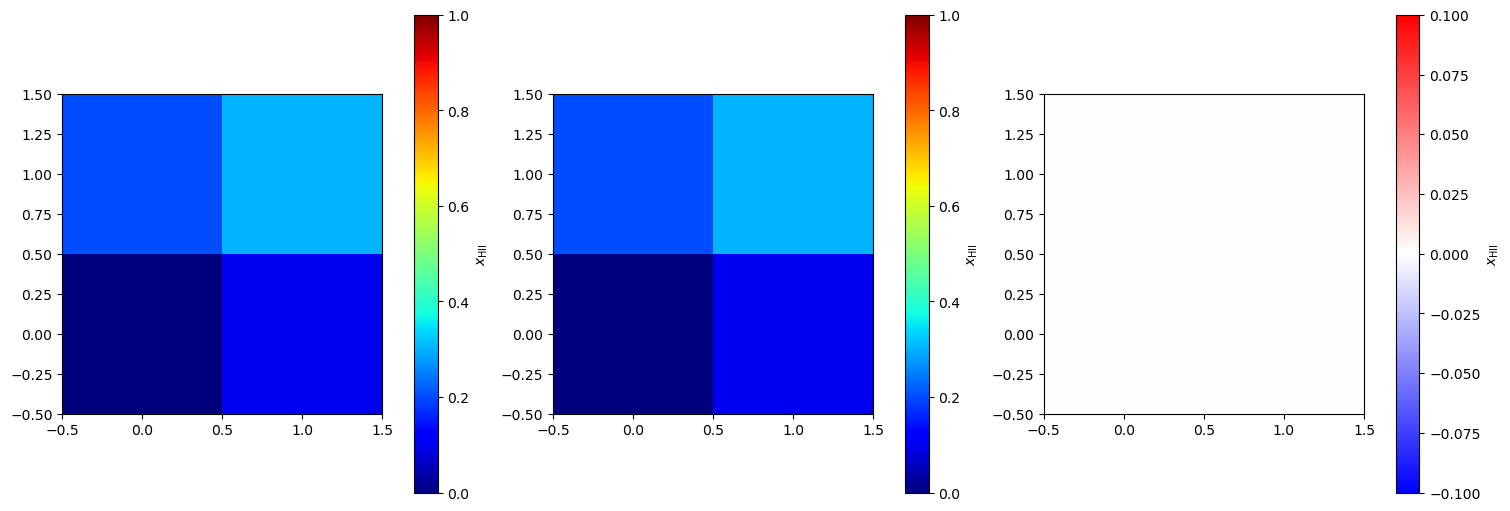

In [24]:
fig, axs = plt.subplots(figsize=(15,5), ncols=3, nrows=1, layout="constrained")
im = axs[0].imshow(new_xh[0], origin='lower', cmap='jet', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0], label=r'$x_{\rm HII}$')

im = axs[1].imshow(xhc2ray[0], origin='lower', cmap='jet', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1], label=r'$x_{\rm HII}$')

im = axs[2].imshow(xhc2ray[0]-new_xh[0], origin='lower', cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar(im, ax=axs[2], label=r'$x_{\rm HII}$')


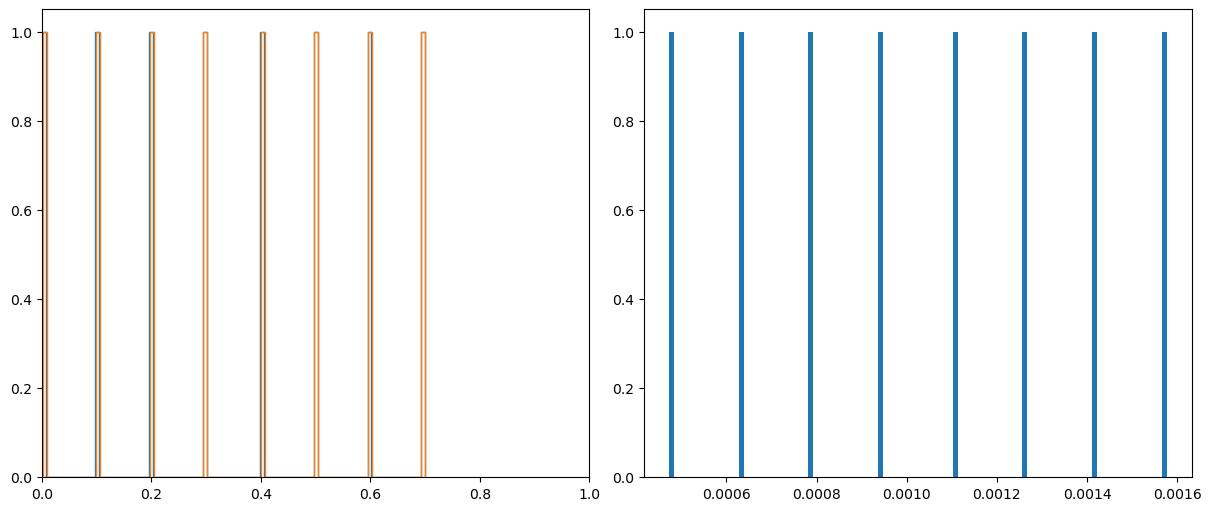

In [25]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1, layout="constrained")
axs[0].hist(xh.flatten(), bins=100, histtype='step');
axs[0].hist(xhc2ray.flatten(), bins=100, histtype='step');
axs[0].set_xlim(0,1)

axs[1].hist(xhc2ray.flatten()-xh.flatten(), bins=100);

In [21]:
xh = np.ones(mesh_shape)*0.1 #np.random.uniform(low=0, high=0.1, size=mesh_shape)
xh_old = xh
abu_c=7.1e-7


# temperature [K]
temp = np.ones(mesh_shape)*1e4

# clumping factor
clumping = np.ones(mesh_shape)

xh_arr2 = np.zeros(t_steps)
bh00=2.59e-13
albpow=-0.7
colh0=1.3e-8
abu_c=7.1e-7
temph0 = (13.598*u.eV/cst.k_B).cgs.value

epsilon = 1e-14

#xh_intermed = xh_ini
for i in range(t_steps):
    #xh_intermed = xh
    #conv_flag = p2c.chemistry.global_pass(dt.cgs.value, ndens, temp, xh, xh, xh_intermed, phi_ion, clumping, bh00, albpow, colh0, temph0, abu_c, xh.shape[0], xh.shape[1], xh.shape[2])
    #xh_arr2[i] = xh_intermed
    
    # collisional ionizaiton 
    rhe = ndens * (xh + abu_c)

    acolh0 = colh0 * np.sqrt(temp) * np.exp(-temph0 / temp)
    aih0 = phi_ion + rhe * acolh0

    # Recombination rate
    brech0 = clumping * bh00 * (temp / 1e4)**albpow
    delth = aih0 + rhe * brech0

    # equilibrium solution
    eqxh = aih0 / delth

    # time scale, t_i
    deltht = delth * dt.cgs.value

    # analytical solution
    xh = eqxh + (xh_old - eqxh) * np.exp(-deltht)
    if xh < epsilon:
        xh = epsilon

    # time-averaged ionization fraction
    if deltht < 1.0e-8:
        xh_av = eqxh + (xh_old - eqxh)
    else:
        xh_av = eqxh + (xh_old - eqxh) * (1.0 - np.exp(-deltht)) / deltht

    if xh_av < epsilon:
        xh_av = epsilon

    # update previous timestep
    xh_arr2[i] = xh_av
    xh_old = xh_av